<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 3
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Ensambles: K Nearest Neighbors (KNN)

Dado a que se va a entrenar un modelo utilizando KNN, se decidió que las columnas que fueron transformadas a booleanas dejarlas como eran originalmente y a las columnas con valores numéricos normalizarlas. 

La normalización era algo inútil al entrenar árboles, pero siendo que para las variables categóricas se hace les hace one-hot encoding, la distancia entre los extremos de estas será siempre de 1, mientras que las distancias de algunas columnas numéricas será de hasta 600, prácticamente descartando la información de las otras. De esta manera las distancias entre las diferentes columnas tendrán el mismo peso.

In [54]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor


# Aclaración:
# Hay un warning que puede llegar a aparecer que es debido a una actualización interna de Seaborn que será deprecada, para solucionarlo hay que modificar el código de python
# directamente (lo cual no es una buena práctica).
# La función en concreto se va a seguir utilizando, por lo que no afecta a nuestro código en sí, si no al comportamiento interno de dicha función.
# Se propone ignorar dicho warninig, ya que se solucionará en la próxima versión de Python
# En el siguiente enlace se puede encontrar más información:
# https://github.com/ultralytics/ultralytics/issues/4729
# https://github.com/mwaskom/seaborn/issues/3462
#
# se puede ignorar descomentando las siguientes líneas

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

# o bien otra solución (más elegante), es obtener dicha actualización corriendo esta línea:
# pip install -U ultralytics

In [55]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()

#Eliminación de columnas irrelevantes
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Eliminación de filas con valores nulos
hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

#Eliminación de filas con outliers
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

#Se crea la columna que dice si se asignó la habitación pedida
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False
hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in hotels_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    hotels_df_mod[col] = scaler.fit_transform(hotels_df_mod[[col]])

#One-hot encoding para las columnas categóricas
hotels_df_mod = pd.get_dummies(hotels_df_mod, columns=["hotel",
    "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type",
    "deposit_type", "customer_type", "agent" ], drop_first=True)

hotels_df_mod = hotels_df_mod.reindex(sorted(hotels_df_mod.columns), axis=1)

In [56]:
df_y = hotels_df_mod['is_canceled'].copy()
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=0)

KNN_Classifier = KNeighborsClassifier()

params_grid = {'metric':['euclidean','minkowski'],
               'n_neighbors': list(range(1, 100, 5)),
               'weights':['uniform','distance'],
               'n_jobs':[-1],
               }

folds=16

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

randomcv = RandomizedSearchCV(estimator=KNN_Classifier,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=1 #va 100
                              )


model = randomcv.fit(x_train,y_train)

print("Folds:",folds, "Hiperparametros:",randomcv.best_params_, "F1-Score:",randomcv.best_score_)

Folds: 16 Hiperparametros: {'weights': 'uniform', 'n_neighbors': 56, 'n_jobs': -1, 'metric': 'minkowski'} F1-Score: 0.7982288656916968


In [57]:
df_y = hotels_df_mod['is_canceled'].copy()
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=0)

KNN_Classifier = KNeighborsClassifier()

params_grid = {'metric':['euclidean','minkowski'],
               'n_neighbors': [5], #Va list(range(1, 20)),
               'weights':['uniform','distance'],
               'n_jobs':[-1]}

folds=16

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = make_scorer(f1_score)

randomcv = GridSearchCV(estimator=KNN_Classifier,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv
                              )


model = randomcv.fit(x_train,y_train)

print("Folds:",folds, "Hiperparametros:",randomcv.best_params_, "F1-Score:",randomcv.best_score_)

Folds: 16 Hiperparametros: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'} F1-Score: 0.8168630246800171


Habiendo optimizado los hiperparámetros que se consideraron más relevantes, se obtuvo que el mejor modelo KNN utiliza distancia euclídea y 5 vecinos, obteniéndose un F1-Score de 0,812. Esto no es una mejora sobre el modelo de árbol entrenado en el checkpoint previo. 

## Predicción del test armado a partir de hotels_train

In [58]:
model = KNeighborsClassifier()
model.set_params(metric='euclidean', n_neighbors=5, weights='distance')
model.fit(x_train, y_train);

In [59]:
y_pred=model.predict(x_test)
y_pred

#Accuracy test
print ("Fracción de aciertos:", accuracy_score(y_test, y_pred))

Fracción de aciertos: 0.8117046283537327


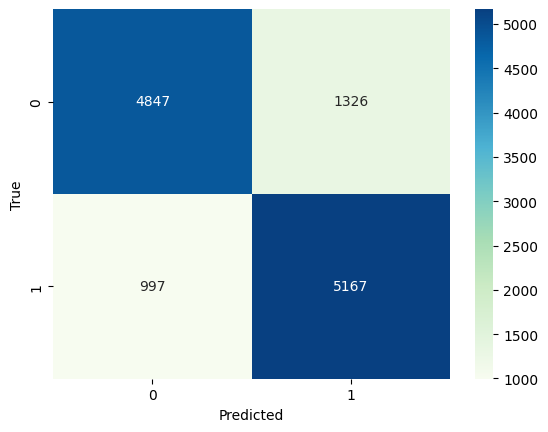

In [60]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [61]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

print(classification_report(y_test,y_pred))

Accuracy: 0.8117046283537327
Recall: 0.8382543802725503
Precision: 0.7957800708455259
f1 score: 0.816465197124121
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      6173
         1.0       0.80      0.84      0.82      6164

    accuracy                           0.81     12337
   macro avg       0.81      0.81      0.81     12337
weighted avg       0.81      0.81      0.81     12337



## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [64]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False
test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)

id_backup = test_df_mod[['id']].copy()

test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns')

test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

#Se crean las columnas que están en el df para entrenar pero no en el df a precedir
for col in df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [68]:
#Se realiza una predicción sobre test utilizando el modelo
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('entrega.csv', index=False)